# Setup


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import timeseriesfcst.preprocessing as tsprep
import timeseriesfcst.lstm as tslstm
import timeseriesfcst.evaluation as eval

from tensorflow.keras.optimizers import Adam

2024-07-29 15:45:00.703395: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 15:45:01.147189: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 15:45:01.251347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 15:45:01.809947: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-29 15:45:07.579057: W tensorflow/compiler/tf2

# Define Constants


In [2]:
REPO_PATH = "hf://datasets/Creatorin/solarpower/"
REPO_PATH_SELECTED = "hf://datasets/Creatorin/solar_selected/"
REPO_PATH_PCA = "hf://datasets/Creatorin/solar_pca/"

SEQUENCE_LENGTH = 24
BATCH_SIZE = 8
TARGET_COLUMN = 'Leistung'
NUM_EPOCHS = 2
OPTIMIZER = Adam(learning_rate=0.0001)

# Set random seed
np.random.seed(42)

# Load Data from Huggingface


In [3]:
# Original Dataset (No Feature Engineering)
splits = {'train': 'train_ts.csv', 'validation': 'val_ts.csv', 'test': 'test_ts.csv'}

train_ts = pd.read_csv(REPO_PATH + splits["train"], index_col=0, date_format="%Y-%m-%d %H:%M:%S")
val_ts = pd.read_csv(REPO_PATH + splits["validation"], index_col=0, date_format="%Y-%m-%d %H:%M:%S")
test_ts = pd.read_csv(REPO_PATH + splits["test"], index_col=0, date_format="%Y-%m-%d %H:%M:%S")


# Dataset with Selected Features
splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}

train_selected = pd.read_parquet(REPO_PATH_SELECTED + splits["train"])
val_selected = pd.read_parquet(REPO_PATH_SELECTED + splits["validation"])
test_selected = pd.read_parquet(REPO_PATH_SELECTED + splits["test"])

# set index
train_selected.set_index("__index_level_0__", inplace=True)
val_selected.set_index("__index_level_0__", inplace=True)
test_selected.set_index("__index_level_0__", inplace=True)

# Datetime
train_selected.index = pd.to_datetime(train_selected.index)
val_selected.index = pd.to_datetime(val_selected.index)
test_selected.index = pd.to_datetime(test_selected.index)

# PCA Dataset
splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}

train_pca = pd.read_parquet("hf://datasets/Creatorin/solar_pca/" + splits["train"])
val_pca = pd.read_parquet("hf://datasets/Creatorin/solar_pca/" + splits["validation"])
test_pca = pd.read_parquet("hf://datasets/Creatorin/solar_pca/" + splits["test"])

# set index
train_pca.set_index("__index_level_0__", inplace=True)
val_pca.set_index("__index_level_0__", inplace=True)
test_pca.set_index("__index_level_0__", inplace=True)

# Datetime
train_pca.index = pd.to_datetime(train_pca.index)
val_pca.index = pd.to_datetime(val_pca.index)
test_pca.index = pd.to_datetime(test_pca.index)

# Confirm Shapes
print(f"Train Shape Original: {train_ts.shape}, Validation Shape: {val_ts.shape}, Test Shape: {test_ts.shape}")
print(f"Train Shape Selected: {train_selected.shape}, Validation Shape: {val_selected.shape}, Test Shape: {test_selected.shape}")
print(f"Train Shape PCA: {train_pca.shape}, Validation Shape: {val_pca.shape}, Test Shape: {test_pca.shape}")

Train Shape Original: (70129, 31), Validation Shape: (8760, 31), Test Shape: (2926, 31)
Train Shape Selected: (61368, 50), Validation Shape: (8759, 50), Test Shape: (2925, 50)
Train Shape PCA: (61368, 617), Validation Shape: (8759, 617), Test Shape: (2925, 617)


In [4]:
# Verify Dates
print(train_ts.index.min())
print(train_ts.index.max())

print(train_selected.index.min())
print(train_selected.index.max())

print(train_pca.index.min())
print(train_pca.index.max())

2014-12-31 23:00:00+00:00
2022-12-31 23:00:00+00:00
2016-01-01 00:00:00+00:00
2022-12-31 23:00:00+00:00
2016-01-01 00:00:00+00:00
2022-12-31 23:00:00+00:00


# Prepare Data for LSTM


In [7]:
# Normalise orignal dataset (the others are already normalised)
train_ts, val_ts, test_ts = tsprep.normalise_ts(train_ts, val_ts, test_ts)

In [8]:
# Create Sequences
X_train, y_train = tslstm.create_sequences(train_ts, TARGET_COLUMN, SEQUENCE_LENGTH, BATCH_SIZE)
X_val, y_val = tslstm.create_sequences(val_ts, TARGET_COLUMN, SEQUENCE_LENGTH, BATCH_SIZE)
X_test, y_test = tslstm.create_sequences(test_ts, TARGET_COLUMN, SEQUENCE_LENGTH, BATCH_SIZE)

# Create Sequences for selected features
X_train_selected, y_train_selected = tslstm.create_sequences(train_selected, TARGET_COLUMN, SEQUENCE_LENGTH, BATCH_SIZE)
X_val_selected, y_val_selected = tslstm.create_sequences(val_selected, TARGET_COLUMN, SEQUENCE_LENGTH, BATCH_SIZE)
X_test_selected, y_test_selected = tslstm.create_sequences(test_selected, TARGET_COLUMN, SEQUENCE_LENGTH, BATCH_SIZE)

# Create Sequences for PCA features
X_train_pca, y_train_pca = tslstm.create_sequences(train_pca, TARGET_COLUMN, SEQUENCE_LENGTH, BATCH_SIZE)
X_val_pca, y_val_pca = tslstm.create_sequences(val_pca, TARGET_COLUMN, SEQUENCE_LENGTH, BATCH_SIZE)
X_test_pca, y_test_pca = tslstm.create_sequences(test_pca, TARGET_COLUMN, SEQUENCE_LENGTH, BATCH_SIZE)

# Print the shapes
print("Training set - X shape:", X_train.shape, "y shape:", y_train.shape)
print("Validation set - X shape:", X_val.shape, "y shape:", y_val.shape)
print("Test set - X shape:", X_test.shape, "y shape:", y_test.shape)

print("")
print("Training set selected - X shape:", X_train_selected.shape, "y shape:", y_train_selected.shape)
print("Validation set selected - X shape:", X_val_selected.shape, "y shape:", y_val_selected.shape)
print("Test set selected - X shape:", X_test_selected.shape, "y shape:", y_test_selected.shape)

print("")
print("Training set pca - X shape:", X_train_pca.shape, "y shape:", train_pca.shape)
print("Validation set pca - X shape:", X_val_pca.shape, "y shape:", y_val_pca.shape)
print("Test set pca - X shape:", X_test_pca.shape, "y shape:", y_test_pca.shape)

Training set - X shape: (70105, 1, 31) y shape: (70105,)
Validation set - X shape: (8736, 1, 31) y shape: (8736,)
Test set - X shape: (2902, 1, 31) y shape: (2902,)

Training set selected - X shape: (61344, 1, 50) y shape: (61344,)
Validation set selected - X shape: (8735, 1, 50) y shape: (8735,)
Test set selected - X shape: (2901, 1, 50) y shape: (2901,)

Training set pca - X shape: (61344, 1, 617) y shape: (61368, 617)
Validation set pca - X shape: (8735, 1, 617) y shape: (8735,)
Test set pca - X shape: (2901, 1, 617) y shape: (2901,)


# LSTM with Original Dataset
## Train

In [34]:
# Create the model
input_shape = (X_train.shape[1], X_train.shape[2])
model = tslstm.create_lstm_model(input_shape, optimizer=OPTIMIZER)

# Train the model
history = tslstm.train_lstm_model(
    model, X_train, y_train, X_val, y_val, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE
)

# Evaluate the model
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")

# Plot train val losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Original Dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

/home/moonchild/PycharmProjects/solar-prediction/solarvenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Num GPUs Available:  0
Epoch 1/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.4090 - val_loss: 0.2325
Epoch 2/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.1115 - val_loss: 0.1654
Epoch 3/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0947 - val_loss: 0.1629
Epoch 4/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0888 - val_loss: 0.1605
Epoch 5/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0890 - val_loss: 0.1535
Epoch 6/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0862 - val_loss: 0.1574
Epoch 7/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0855 - val_loss: 0.1522
Epoch 8/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - loss: 0.0857 - val_loss: 0.1550
Epoch 9/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0846 - val_loss: 0.1487
Epoch 10/10
2191/2191 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0836 - val_loss: 0.1479
Test Loss: 0.2164870649576187
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
{'mae': 0.229983

## Predict

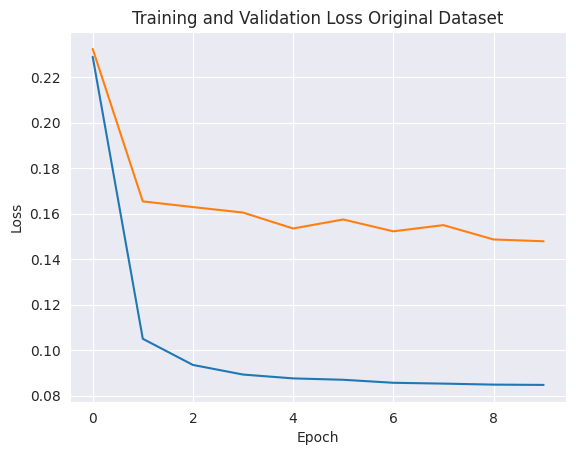

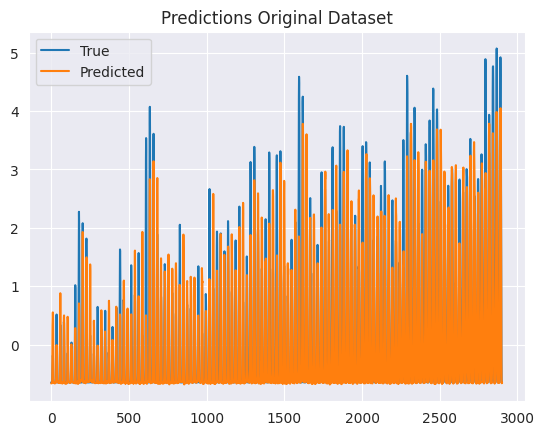

In [35]:
# Make predictions
predictions = model.predict(X_test)

# Plot predictions 
plt.plot(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(predictions, label='Predicted')
plt.title('Predictions Original Dataset')
plt.legend()
plt.show()

# Get performance metrics
metrics = eval.evaluate_model(y_test, predictions)
print(metrics)

## Feature Importance


In [ ]:
# Calculate permutation importance
importances = eval.permutation_importance(model, X_test, y_test)

# get feature names (column names)
feature_names = train_ts.columns

# Create a DataFrame for easier plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance (Increase in MSE)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print feature importance
print(importance_df)

# LSTM with Selected Features
## Train

In [36]:
# Create the model
input_shape = (X_train_selected.shape[1], X_train_selected.shape[2])
model = tslstm.create_lstm_model(input_shape)

# Train the model
history = tslstm.train_lstm_model(
    model, X_train_selected, y_train_selected, X_val_selected, y_val_selected, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE
)

# Evaluate the model
test_loss = model.evaluate(X_test_selected, y_test_selected, verbose=0)
print(f"Test Loss: {test_loss}")

# Plot train val losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Selected Features')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

/home/moonchild/PycharmProjects/solar-prediction/solarvenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Num GPUs Available:  0
Epoch 1/10
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.9073 - val_loss: 1.9806
Epoch 2/10
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7938 - val_loss: 1.9173
Epoch 3/10
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8062 - val_loss: 1.9144
Epoch 4/10
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.8024 - val_loss: 1.9131
Epoch 5/10
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7866 - val_loss: 1.8888
Epoch 6/10
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.7798 - val_loss: 1.8795
Epoch 7/10
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7795 - val_loss: 1.8992
Epoch 8/10
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7764 - val_loss: 1.9060
Epoch 9/10
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7604 - val_loss: 1.8562
Epoch 10/10
1917/1917 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7649 - val_loss: 1.8983
Test Loss: 2.6202142238616943
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
{'mae': 0.94108153172553

## Predict


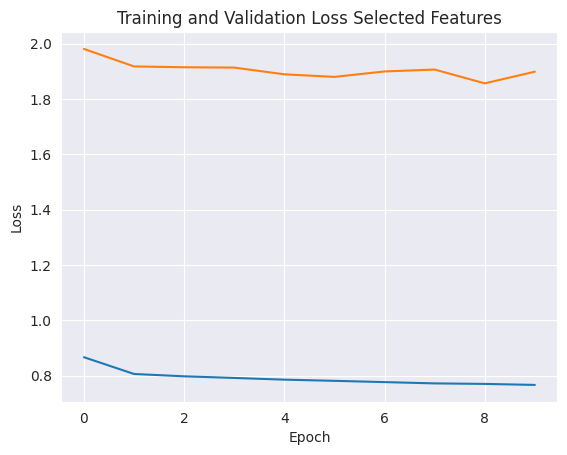

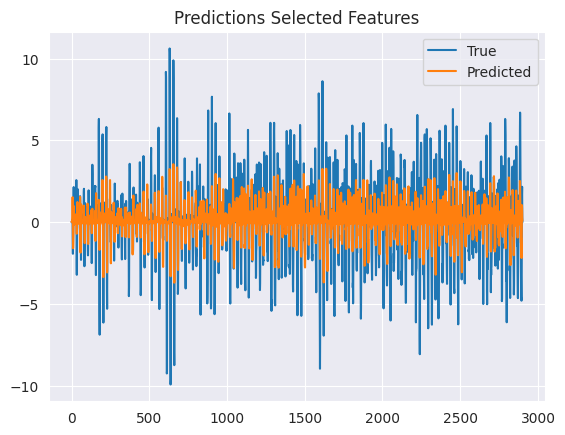

In [37]:
# Make predictions
predictions = model.predict(X_test_selected)

# Plot predictions
plt.plot(figsize=(10, 6))
plt.plot(y_test_selected, label='True')
plt.plot(predictions, label='Predicted')
plt.title('Predictions Selected Features')
plt.legend()
plt.show()

# Get performance metrics
metrics = eval.evaluate_model(y_test_selected, predictions)
print(metrics)

# LSTM with PCA Features
## Train

In [38]:
# Create the model
input_shape = (X_train_pca.shape[1], X_train_pca.shape[2])
model = tslstm.create_lstm_model(input_shape)

# Train the model
history = tslstm.train_lstm_model(
    model, X_train_pca, y_train_pca, X_val_pca, y_val_pca, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE
)

# Evaluate the model
test_loss = model.evaluate(X_test_pca, y_test_pca, verbose=0)
print(f"Test Loss: {test_loss}")

# Plot train val losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss PCA Features')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

/home/moonchild/PycharmProjects/solar-prediction/solarvenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Num GPUs Available:  0


2024-07-29 01:23:15.274069: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 302793984 exceeds 10% of free system memory.
2024-07-29 01:23:15.713723: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 43115960 exceeds 10% of free system memory.


Epoch 1/10


2024-07-29 01:23:15.803322: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 151396992 exceeds 10% of free system memory.


ValueError: Unknown variable: <KerasVariable shape=(617, 200), dtype=float32, path=sequential_2/lstm_4/lstm_cell/kernel>. This optimizer can only be called for the variables it was originally built with. When working with a new set of variables, you should recreate a new optimizer instance.

## Predict

In [ ]:
# Make predictions
predictions = model.predict(X_test_pca)

# Get performance metrics
metrics = eval.evaluate_model(y_test_pca, predictions)
print(metrics)

# Plot predictions
plt.plot(figsize=(10, 6))
plt.plot(y_test_pca, label='True')
plt.plot(predictions, label='Predicted')
plt.title('Predictions PCA Features')
plt.legend()
plt.show()